In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import vector
import boost_histogram as bh
import mplhep as hep

In [2]:
def histogram(data, bins, data_label, axes, density=True, ratio=True, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)


### Load data

In [3]:
def data_generator(input_file,channel):
    tree = uproot.open(f"{input_file}")
    tree_reco = tree['Reco;1']
    tree_tops = tree['Top;1']

    top_pt = tree_tops['pt'].array()
    top_eta = tree_tops['eta'].array()
    top_phi = tree_tops['phi'].array()
    top_energy = tree_tops['energy'].array()

    tops = vector.zip({'pt': top_pt, 'eta': top_eta, 'phi': top_phi, 'E': top_energy})

    reco_pt = tree_reco['pt'].array()
    reco_eta = tree_reco['eta'].array()
    reco_phi = tree_reco['phi'].array()
    reco_energy = tree_reco['energy'].array()

    jets = vector.zip({'pt': reco_pt,'eta': reco_eta, 'phi': reco_phi, 'energy': reco_energy})

    reco_indices = tree_reco['matching_indices'].array()
    print(reco_indices)
    
    pad_length = len(reco_indices[0])

    if channel == "3t":
        b_mask = (reco_indices > 0) & (reco_indices < 4)
        jet_mask = reco_indices > 3
    if channel == "4t":
        b_mask = (reco_indices > 0) & (reco_indices < 5)
        jet_mask = reco_indices > 4


    reco_pt_pad_none = ak.pad_none(reco_pt,pad_length)
    reco_pt_pad = ak.fill_none(reco_pt_pad_none,0)
    b_pt = ak.flatten(ak.mask(reco_pt_pad,b_mask))[~ak.is_none(ak.flatten(ak.mask(reco_pt_pad,b_mask)))]

    reco_eta_pad_none = ak.pad_none(reco_eta,pad_length)
    reco_eta_pad = ak.fill_none(reco_eta_pad_none,0)
    b_eta = ak.flatten(ak.mask(reco_eta_pad,b_mask))[~ak.is_none(ak.flatten(ak.mask(reco_eta_pad,b_mask)))]

    reco_phi_pad_none = ak.pad_none(reco_phi,pad_length)
    reco_phi_pad = ak.fill_none(reco_phi_pad_none,0)

    b_phi = ak.flatten(ak.mask(reco_phi_pad,b_mask))[~ak.is_none(ak.flatten(ak.mask(reco_phi_pad,b_mask)))]

    reco_energy_pad_none = ak.pad_none(reco_energy,pad_length)
    reco_energy_pad = ak.fill_none(reco_energy_pad_none,0)
    b_energy = ak.flatten(ak.mask(reco_energy_pad,b_mask))[~ak.is_none(ak.flatten(ak.mask(reco_energy_pad,b_mask)))]

    reco_pt_masked = ak.flatten(ak.mask(reco_pt_pad,jet_mask))
    reco_pt_non_none = reco_pt_masked[~ak.is_none(reco_pt_masked)]
    reco_pt_matched = ak.unflatten(reco_pt_non_none,2)

    reco_eta_masked = ak.flatten(ak.mask(reco_eta_pad,jet_mask))
    reco_eta_non_none = reco_eta_masked[~ak.is_none(reco_eta_masked)]
    reco_eta_matched = ak.unflatten(reco_eta_non_none,2)

    reco_phi_masked = ak.flatten(ak.mask(reco_phi_pad,jet_mask))
    reco_phi_non_none = reco_phi_masked[~ak.is_none(reco_phi_masked)]
    reco_phi_matched = ak.unflatten(reco_phi_non_none,2)

    reco_energy_masked = ak.flatten(ak.mask(reco_energy_pad,jet_mask))
    reco_energy_non_none = reco_energy_masked[~ak.is_none(reco_energy_masked)]
    reco_energy_matched = ak.unflatten(reco_energy_non_none,2)

    reco_matched = vector.zip({'pt': reco_pt_matched, 'eta': reco_eta_matched, 'phi': reco_phi_matched, 'E': reco_energy_matched})
    b_jet = vector.zip({'pt': b_pt, 'eta': b_eta, 'phi': b_phi, 'E': b_energy})

    return tops, jets, reco_matched, b_jet

# Run the function
tops_3t, jets_3t, not_b_jets_matched_3t, b_jet_3t = data_generator("../sm_3t_0L_14Feb.root","3t")
tops_4t, jets_4t, not_b_jets_matched_4t, b_jet_4t = data_generator("../sm_4t_0L_25Feb.root","4t")

matched_jets_3t = ak.concatenate((not_b_jets_matched_3t,ak.unflatten(b_jet_3t,1)),axis=1)
matched_jets_4t = ak.concatenate((not_b_jets_matched_4t,ak.unflatten(b_jet_4t,1)),axis=1)

[[-8, 5, -8, 1, 4, -8, -8, -8, -9, ..., -9, -9, -9, -9, -9, -9, -9, -9], ...]
[[-8, -8, -8, -8, -8, -8, 6, 1, 5, ..., -9, -9, -9, -9, -9, -9, -9, -9], ...]


### $\Delta R$

In [4]:
def delta_r_top_reco(jet, top):
    jet_1 = jet[:,0]
    jet_2 = jet[:,1]
    jet_3 = jet[:,2]

    delta_r_1 = jet_1.deltaR(top)
    delta_r_2 = jet_2.deltaR(top)
    delta_r_3 = jet_3.deltaR(top)
    delta_r = np.concatenate([delta_r_1, delta_r_2, delta_r_3],axis=1)
    return delta_r

delta_r_3t = delta_r_top_reco(jets_3t, tops_3t)
delta_r_4t = delta_r_top_reco(jets_4t, tops_4t)

### Centrality

In [5]:
def centrality(jets,b_jet):
    jet_1 = jets.rapidity[:,0]
    jet_2 = jets.rapidity[:,1]

    return np.abs((b_jet.rapidity - 0.5*(jet_1 + jet_2))/abs(jet_1 - jet_2))
centrality_3t = centrality(not_b_jets_matched_3t,b_jet_3t)
centrality_4t = centrality(not_b_jets_matched_4t,b_jet_4t)

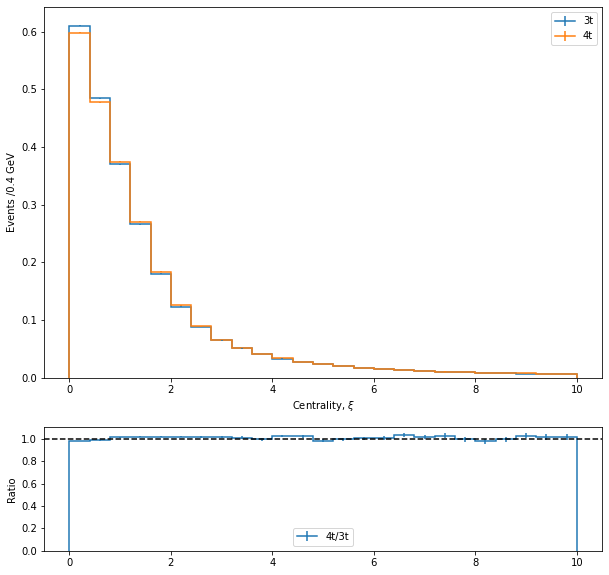

In [6]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([centrality_3t, centrality_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1], set_range=(0,10))
ax[0].set_xlabel(r'Centrality, $\xi$')
plt.show()

3191235


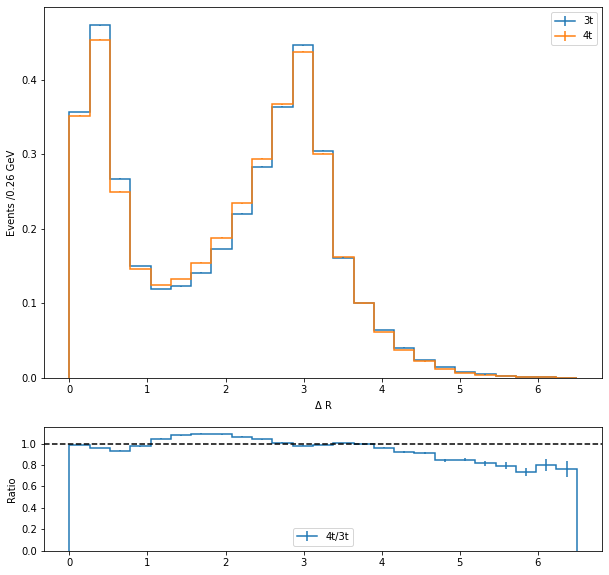

In [7]:
delta_r_3t_all = ak.flatten(delta_r_3t,axis=1)
print(len(delta_r_3t_all))
delta_r_4t_all = ak.flatten(delta_r_4t,axis=1)
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([ak.flatten(delta_r_3t), ak.flatten(delta_r_4t)], 25, ['3t','4t'], ax[0], ratio_axes=ax[1], set_range=(0,6.5))
ax[0].set_xlabel(r'$\Delta$ R')
plt.show()

### Invariant mass 

In [8]:
invariant_mass_jets_3t = np.sum(not_b_jets_matched_3t.M,axis=1)
invariant_mass_jets_4t = np.sum(not_b_jets_matched_4t.M,axis=1)

print(invariant_mass_jets_3t)
print(invariant_mass_jets_4t)

[30.4, 28.3, 13.2, 7.41, 15.6, 18.7, ..., 15, 66.8, 11.8, 27.9, 26.3, 9.42]
[11, 10.6, 26, 22.8, 12.3, 12.7, 10.3, ..., 19, 19.9, 20.7, 55, 14, 13, 20.3]


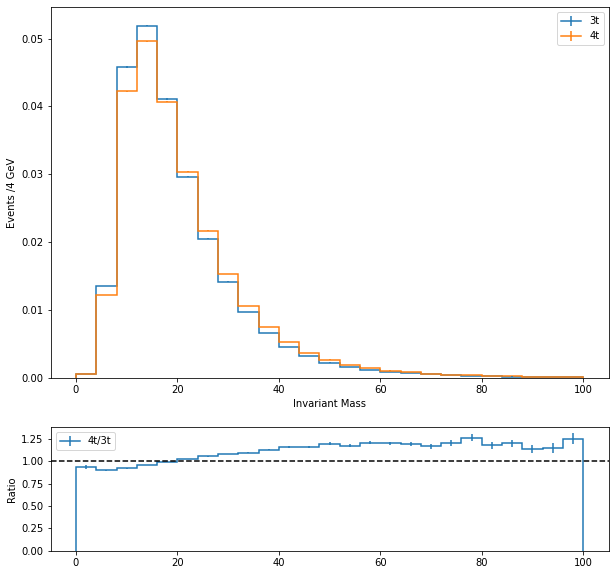

In [9]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([invariant_mass_jets_3t,invariant_mass_jets_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1],set_range=(0,100))
ax[0].set_xlabel(r'Invariant Mass')
plt.show()

### Boost

In [10]:
tops_3t_padded = ak.pad_none(tops_3t,3,axis=1)
print(ak.num(tops_3t_padded))
tops_3t_broadcasted = ak.fill_none(tops_3t_padded,tops_3t)
print(tops_3t_broadcasted)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..., 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[[{rho: 164, phi: -2.65, eta: -0.969, t: 310}, [...], [[{...}], ...]], ...]


In [11]:
print(ak.num(matched_jets_3t))  # Check the size of jets_3t
print(len(ak.num(tops_3t_broadcasted[0,1])))  # Check the size of tops_3t_broadcasted
print(tops_3t_broadcasted[0,1])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..., 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
1063745
[[{rho: 164, phi: -2.65, eta: -0.969, t: 310}], [{...}], ..., [{rho: 145, ...}]]


In [12]:
def data_generator_dm(input_file,channel):
    tree = uproot.open(f"{input_file}")
    tree_reco = tree['Reco;1']
    tree_tops = tree['Top;1']

    top_pt = tree_tops['pt'].array()
    print(len(top_pt))
    top_eta = tree_tops['eta'].array()
    top_phi = tree_tops['phi'].array()
    top_energy = tree_tops['energy'].array()

    tops = vector.zip({'pt': top_pt, 'eta': top_eta, 'phi': top_phi, 'E': top_energy})

    reco_pt = tree_reco['pt'].array()
    reco_eta = tree_reco['eta'].array()
    reco_phi = tree_reco['phi'].array()
    reco_energy = tree_reco['energy'].array()

    jets = vector.zip({'pt': reco_pt,'eta': reco_eta, 'phi': reco_phi, 'energy': reco_energy})

    reco_indices = tree_reco['matching_indices'].array()
    print(len(reco_indices[0]))


    pad_length = len(reco_indices[0])

    if channel == "3t":
        jet12_mask = ((reco_indices == 1) | (reco_indices == 4) | (reco_indices == 5) | (reco_indices == 2) | (reco_indices == 6) | (reco_indices == 7))
        jet13_mask = ((reco_indices == 1) | (reco_indices == 4) | (reco_indices == 5) | (reco_indices == 3) | (reco_indices == 8) | (reco_indices == 9))
        jet23_mask = ((reco_indices == 2) | (reco_indices == 6) | (reco_indices == 7) | (reco_indices == 3) | (reco_indices == 8) | (reco_indices == 9))

        b12_mask = (reco_indices == 1) | (reco_indices == 2)        
        b13_mask = (reco_indices == 1) | (reco_indices == 3)        
        b23_mask = (reco_indices == 2) | (reco_indices == 3)


    if channel == "4t":
        jet12_mask = ((reco_indices == 1) | (reco_indices == 5) | (reco_indices == 6) | (reco_indices == 2) | (reco_indices == 7) | (reco_indices == 8))
        jet13_mask = ((reco_indices == 1) | (reco_indices == 5) | (reco_indices == 6) | (reco_indices == 3) | (reco_indices == 9) | (reco_indices == 10))
        jet14_mask = ((reco_indices == 1) | (reco_indices == 5) | (reco_indices == 6) | (reco_indices == 4) | (reco_indices == 11) | (reco_indices == 12))
        jet23_mask = ((reco_indices == 2) | (reco_indices == 7) | (reco_indices == 8) | (reco_indices == 3) | (reco_indices == 9) | (reco_indices == 10))
        jet24_mask = ((reco_indices == 2) | (reco_indices == 7) | (reco_indices == 8) | (reco_indices == 4) | (reco_indices == 11) | (reco_indices == 12))
        jet34_mask = ((reco_indices == 3) | (reco_indices == 9) | (reco_indices == 10) | (reco_indices == 4) | (reco_indices == 11) | (reco_indices == 12))


        b12_mask = (reco_indices == 1) | (reco_indices == 2)        
        b13_mask = (reco_indices == 1) | (reco_indices == 3)     
        b14_mask = (reco_indices == 1) | (reco_indices == 4)    
        b23_mask = (reco_indices == 2) | (reco_indices == 3)   
        b24_mask = (reco_indices == 2) | (reco_indices == 4)
        b34_mask = (reco_indices == 3) | (reco_indices == 4)
        
    
    print("Matching b jet data")
    reco_pt_pad_none = ak.pad_none(reco_pt,pad_length)
    reco_pt_pad = ak.fill_none(reco_pt_pad_none,0)
    b12_pt = ak.drop_none(ak.mask(reco_pt_pad,b12_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,b12_mask)))>1]
    b13_pt = ak.drop_none(ak.mask(reco_pt_pad,b13_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,b13_mask)))>1]
    b23_pt = ak.drop_none(ak.mask(reco_pt_pad,b23_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,b23_mask)))>1]

    if channel == "4t":
        b14_pt = ak.drop_none(ak.mask(reco_pt_pad,b14_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,b14_mask)))>1]
        b24_pt = ak.drop_none(ak.mask(reco_pt_pad,b24_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,b24_mask)))>1]
        b34_pt = ak.drop_none(ak.mask(reco_pt_pad,b34_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,b34_mask)))>1]

        b_pt = ak.concatenate((b12_pt,b13_pt,b14_pt,b23_pt,b24_pt,b34_pt),axis=0)
    else:
        b_pt = ak.concatenate((b12_pt,b13_pt,b23_pt),axis=0)

    reco_eta_pad_none = ak.pad_none(reco_eta,pad_length)
    reco_eta_pad = ak.fill_none(reco_eta_pad_none,0)
    b12_eta = ak.drop_none(ak.mask(reco_eta_pad,b12_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,b12_mask)))>1]
    b13_eta = ak.drop_none(ak.mask(reco_eta_pad,b13_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,b13_mask)))>1]
    b23_eta = ak.drop_none(ak.mask(reco_eta_pad,b23_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,b23_mask)))>1]

    if channel == "4t":
        b14_eta = ak.drop_none(ak.mask(reco_eta_pad,b14_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,b14_mask)))>1]
        b24_eta = ak.drop_none(ak.mask(reco_eta_pad,b24_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,b24_mask)))>1]
        b34_eta = ak.drop_none(ak.mask(reco_eta_pad,b34_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,b34_mask)))>1]

        b_eta = ak.concatenate((b12_eta,b13_eta,b14_eta,b23_eta,b24_eta,b34_eta),axis=0)
    else:
        b_eta = ak.concatenate((b12_eta,b13_eta,b23_eta),axis=0)

    reco_phi_pad_none = ak.pad_none(reco_phi,pad_length)
    reco_phi_pad = ak.fill_none(reco_phi_pad_none,0)
    b12_phi = ak.drop_none(ak.mask(reco_phi_pad,b12_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,b12_mask)))>1]
    b13_phi = ak.drop_none(ak.mask(reco_phi_pad,b13_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,b13_mask)))>1]
    b23_phi = ak.drop_none(ak.mask(reco_phi_pad,b23_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,b23_mask)))>1]

    if channel == "4t":
        b14_phi = ak.drop_none(ak.mask(reco_phi_pad,b14_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,b14_mask)))>1]
        b24_phi = ak.drop_none(ak.mask(reco_phi_pad,b24_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,b24_mask)))>1]
        b34_phi = ak.drop_none(ak.mask(reco_phi_pad,b34_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,b34_mask)))>1]

        b_phi = ak.concatenate((b12_phi,b13_phi,b14_phi,b23_phi,b24_phi,b34_phi),axis=0)
    else:
        b_phi = ak.concatenate((b12_phi,b13_phi,b23_phi),axis=0)

    reco_energy_pad_none = ak.pad_none(reco_energy,pad_length)
    reco_energy_pad = ak.fill_none(reco_energy_pad_none,0)
    b12_energy = ak.drop_none(ak.mask(reco_energy_pad,b12_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,b12_mask)))>1]
    b13_energy = ak.drop_none(ak.mask(reco_energy_pad,b13_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,b13_mask)))>1]
    b23_energy = ak.drop_none(ak.mask(reco_energy_pad,b23_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,b23_mask)))>1]

    if channel == "4t":
        b14_energy = ak.drop_none(ak.mask(reco_energy_pad,b14_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,b14_mask)))>1]
        b24_energy = ak.drop_none(ak.mask(reco_energy_pad,b24_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,b24_mask)))>1]
        b34_energy = ak.drop_none(ak.mask(reco_energy_pad,b34_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,b34_mask)))>1]

        b_energy = ak.concatenate((b12_energy,b13_energy,b14_energy,b23_energy,b24_energy,b34_energy),axis=0)
    else:
        b_energy = ak.concatenate((b12_energy,b13_energy,b23_energy),axis=0)

    print("Matching jet data")
    jet12_pt = ak.drop_none(ak.mask(reco_pt_pad,jet12_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,jet12_mask)))>3]
    jet13_pt = ak.drop_none(ak.mask(reco_pt_pad,jet13_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,jet13_mask)))>3]
    jet23_pt = ak.drop_none(ak.mask(reco_pt_pad,jet23_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,jet23_mask)))>3]

    if channel == "4t":
        jet14_pt = ak.drop_none(ak.mask(reco_pt_pad,jet14_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,jet14_mask)))>3]
        jet24_pt = ak.drop_none(ak.mask(reco_pt_pad,jet24_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,jet24_mask)))>3]
        jet34_pt = ak.drop_none(ak.mask(reco_pt_pad,jet34_mask))[ak.num(ak.drop_none(ak.mask(reco_pt_pad,jet34_mask)))>3]


        jet_pt_matched = ak.concatenate((jet12_pt,jet13_pt,jet14_pt,jet23_pt,jet24_pt,jet34_pt),axis=0)
    else:
        jet_pt_matched = ak.concatenate((jet12_pt,jet13_pt,jet23_pt),axis=0)

    jet12_eta = ak.drop_none(ak.mask(reco_eta_pad,jet12_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,jet12_mask)))>3]
    jet13_eta = ak.drop_none(ak.mask(reco_eta_pad,jet13_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,jet13_mask)))>3]
    jet23_eta = ak.drop_none(ak.mask(reco_eta_pad,jet23_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,jet23_mask)))>3]

    if channel == "4t":
        jet14_eta = ak.drop_none(ak.mask(reco_eta_pad,jet14_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,jet14_mask)))>3]
        jet24_eta = ak.drop_none(ak.mask(reco_eta_pad,jet24_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,jet24_mask)))>3]
        jet34_eta = ak.drop_none(ak.mask(reco_eta_pad,jet34_mask))[ak.num(ak.drop_none(ak.mask(reco_eta_pad,jet34_mask)))>3]


        jet_eta_matched = ak.concatenate((jet12_eta,jet13_eta,jet14_eta,jet23_eta,jet24_eta,jet34_eta),axis=0)
    else:
        jet_eta_matched = ak.concatenate((jet12_eta,jet13_eta,jet23_eta),axis=0)
        

    jet12_phi = ak.drop_none(ak.mask(reco_phi_pad,jet12_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,jet12_mask)))>3]
    jet13_phi = ak.drop_none(ak.mask(reco_phi_pad,jet13_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,jet13_mask)))>3]
    jet23_phi = ak.drop_none(ak.mask(reco_phi_pad,jet23_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,jet23_mask)))>3]

    if channel == "4t":
        jet14_phi = ak.drop_none(ak.mask(reco_phi_pad,jet14_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,jet14_mask)))>3]
        jet24_phi = ak.drop_none(ak.mask(reco_phi_pad,jet24_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,jet24_mask)))>3]
        jet34_phi = ak.drop_none(ak.mask(reco_phi_pad,jet34_mask))[ak.num(ak.drop_none(ak.mask(reco_phi_pad,jet34_mask)))>3]


        jet_phi_matched = ak.concatenate((jet12_phi,jet13_phi,jet14_phi,jet23_phi,jet24_phi,jet34_phi),axis=0)
    else:
        jet_phi_matched = ak.concatenate((jet12_phi,jet13_phi,jet23_phi),axis=0)

    jet12_energy = ak.drop_none(ak.mask(reco_energy_pad,jet12_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,jet12_mask)))>3]
    jet13_energy = ak.drop_none(ak.mask(reco_energy_pad,jet13_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,jet13_mask)))>3]
    jet23_energy = ak.drop_none(ak.mask(reco_energy_pad,jet23_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,jet23_mask)))>3]

    if channel == "4t":
        jet14_energy = ak.drop_none(ak.mask(reco_energy_pad,jet14_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,jet14_mask)))>3]
        jet24_energy = ak.drop_none(ak.mask(reco_energy_pad,jet24_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,jet24_mask)))>3]
        jet34_energy = ak.drop_none(ak.mask(reco_energy_pad,jet34_mask))[ak.num(ak.drop_none(ak.mask(reco_energy_pad,jet34_mask)))>3]


        jet_energy_matched = ak.concatenate((jet12_energy,jet13_energy,jet14_energy,jet23_energy,jet24_energy,jet34_energy),axis=0)
    else:
        jet_energy_matched = ak.concatenate((jet12_energy,jet13_energy,jet23_energy),axis=0)
        


    jets_matched = vector.zip({'pt': jet_pt_matched, 'eta': jet_eta_matched, 'phi': jet_phi_matched, 'E': jet_energy_matched})
    print(np.shape(jets_matched.pt))
    b_jet = vector.zip({'pt': b_pt, 'eta': b_eta, 'phi': b_phi, 'E': b_energy})
    print(f"Finished matching {channel} data")
    return tops, jets, jets_matched, b_jet
    
tops_3t_dm, jets_3t_dm, jets_matched_3t_dm, b_jets_3t_dm = data_generator_dm("../dm_3t_0L_14Feb.root","3t")
tops_4t_dm, jets_4t_dm, jets_matched_4t_dm, b_jets_4t_dm = data_generator_dm("../dm_4t_0L_25Feb.root","4t")

365639
21
Matching b jet data
Matching jet data
[365639, 6]
Finished matching 3t data
717047
21
Matching b jet data
Matching jet data
[717047, 6]
Finished matching 4t data


In [13]:
print(np.shape(jets_matched_3t_dm))
print(np.shape(jets_matched_4t_dm))

[365639, 6]
[717047, 6]


In [14]:
print(np.shape(b_jets_3t_dm))

[365639, 2]


In [ ]:
topCM_3t = ak.unflatten(np.sum(tops_3t_dm,axis=1),1)
tops_3t_broadcast_dm = ak.broadcast_arrays(jets_matched_3t_dm,topCM_3t)[1]
jets_3t_boosted = jets_matched_3t_dm.boostCM_of(tops_3t_broadcast_dm)

topCM_4t = ak.unflatten(np.sum(tops_4t_dm,axis=1),1)
tops_4t_broadcast_dm = ak.broadcast_arrays(jets_matched_4t_dm,topCM_4t)[1]
jets_4t_boosted = jets_matched_4t_dm.boostCM_of(tops_4t_broadcast_dm)

print(jets_4t_boosted.pt)


In [ ]:
matched_jet_pt_boosted_3t = ak.flatten(jets_3t_boosted.pt)
matched_jet_pt_boosted_4t = ak.flatten(jets_4t_boosted.pt)

matched_jet_eta_boosted_3t = ak.flatten(jets_3t_boosted.eta)
matched_jet_eta_boosted_4t = ak.flatten(jets_4t_boosted.eta)

matched_jet_phi_boosted_3t = ak.flatten(jets_3t_boosted.phi)
matched_jet_phi_boosted_4t = ak.flatten(jets_4t_boosted.phi)

matched_jet_energy_boosted_3t = ak.flatten(jets_3t_boosted.energy)
matched_jet_energy_boosted_4t = ak.flatten(jets_4t_boosted.energy)

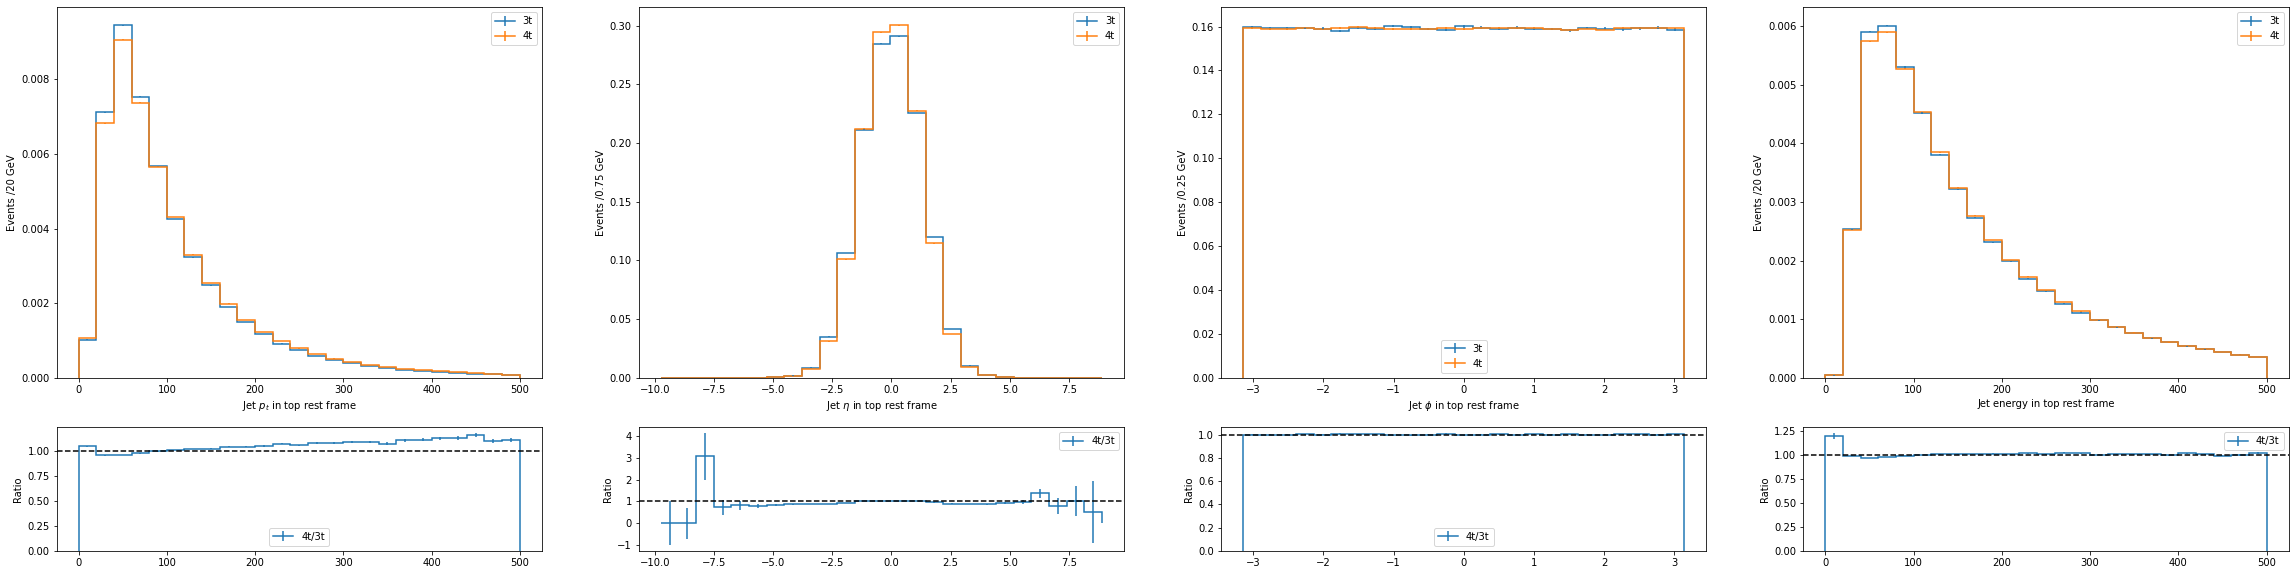

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(40,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([matched_jet_pt_boosted_3t,matched_jet_pt_boosted_4t], 25, ['3t','4t'], ax[0,0], ratio_axes=ax[1,0],set_range=(0,500))
histogram([matched_jet_eta_boosted_3t,matched_jet_eta_boosted_4t], 25, ['3t','4t'], ax[0,1], ratio_axes=ax[1,1])
histogram([matched_jet_phi_boosted_3t,matched_jet_phi_boosted_4t], 25, ['3t','4t'], ax[0,2], ratio_axes=ax[1,2])
histogram([matched_jet_energy_boosted_3t,matched_jet_energy_boosted_4t], 25, ['3t','4t'], ax[0,3], ratio_axes=ax[1,3],set_range=(0,500))
ax[0,0].set_xlabel(r'Jet $p_t$ in top rest frame')
ax[0,1].set_xlabel(r'Jet $\eta$ in top rest frame')
ax[0,2].set_xlabel(r'Jet $\phi$ in top rest frame')
ax[0,3].set_xlabel(r'Jet energy in top rest frame')
plt.show()

In [ ]:
top_1_3t = tops_3t_dm[:,0]
top_2_3t = tops_3t_dm[:,1]
top_1_4t = tops_4t_dm[:,0]
top_2_4t = tops_4t_dm[:,1]

top_1_3t = vector.zip({
    "pt": top_1_3t.px,
    "eta": top_1_3t.eta,
    "phi": top_1_3t.phi
})

top_2_3t = vector.zip({
    "pt": top_2_3t.pt,
    "eta": top_2_3t.eta,
    "phi": top_2_3t.phi
})

z_axis = vector.zip({
    "x":0,
    "y":0,
    "z":1,
})

top_1_4t = vector.zip({
    "pt": top_1_4t.pt,
    "eta": top_1_4t.eta,
    "phi": top_1_4t.phi
})

top_2_4t = vector.zip({
    "pt": top_2_4t.pt,
    "eta": top_2_4t.eta,
    "phi": top_2_4t.phi
})

z_axis = vector.zip({
    "x":0,
    "y":0,
    "z":1,
})

In [ ]:
cross_p_1_3t = top_1_3t.cross(z_axis)
print(len(cross_p_1_3t))
cross_p_2_3t = top_2_3t.cross(z_axis)

cross_p_1_4t = top_1_4t.cross(z_axis)
cross_p_2_4t = top_2_4t.cross(z_axis)

b2_3t = cross_p_1_3t.dot(cross_p_2_3t)/(top_1_3t.p*top_2_3t.p)
print(b2_3t)
b2_4t = cross_p_1_4t.dot(cross_p_2_4t)/(top_1_4t.p*top_2_4t.p)

365639
[0.0287, -0.159, -0.889, -0.0681, -0.281, ..., -0.439, -0.374, -0.696, -0.46]


In [ ]:
b2_3t = (top_1_3t.cross(z_axis)).dot(top_1_3t.cross(z_axis))/(top_1_3t.p*top_2_3t.p)
b2_4t = (top_1_4t.cross(z_axis)).dot(top_1_4t.cross(z_axis))/(top_1_4t.p*top_2_4t.p)

b4_3t = (top_1_3t.dot(z_axis)*top_2_3t.dot(z_axis))/(top_1_3t.p*top_2_3t.p)
b4_4t = (top_1_4t.dot(z_axis)*top_2_4t.dot(z_axis))/(top_1_4t.p*top_2_4t.p)

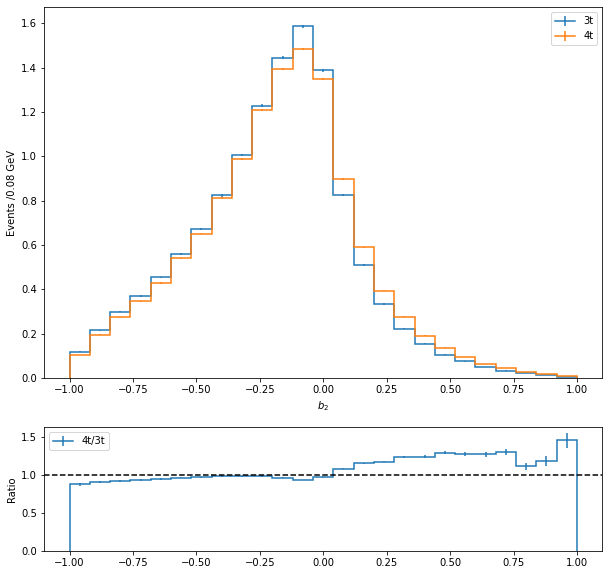

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([b2_3t,b2_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1])
ax[0].set_xlabel(r'$b_2$')
plt.show()

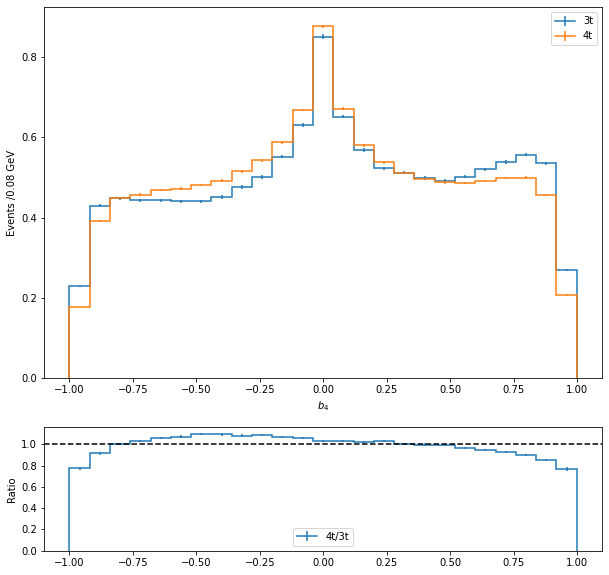

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([b4_3t,b4_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1])
ax[0].set_xlabel(r'$b_4$')
plt.show()

In [ ]:
def delta_r_dm(jets,tops):
    top_1 = tops[:,0]
    top_2 = tops[:,1]
    delta_r_1 = jets.deltaR(top_1)
    delta_r_2 = jets.deltaR(top_2)
    return delta_r_1,delta_r_2

delta_r_1_3t,delta_r_2_3t = delta_r_dm(jets_3t_dm,tops_3t_dm)
delta_r_1_4t,delta_r_2_4t = delta_r_dm(jets_4t_dm,tops_4t_dm)

delta_r_3t = ak.concatenate((delta_r_1_3t,delta_r_2_3t),axis=1)
delta_r_4t = ak.concatenate((delta_r_1_4t,delta_r_2_4t),axis=1)

min_delta_r_3t = delta_r_3t[ak.argsort(delta_r_3t)][:,0]
min_delta_r_4t = delta_r_4t[ak.argsort(delta_r_4t)][:,0]

max_delta_r_3t = delta_r_3t[ak.argsort(delta_r_3t,ascending=False)][:,0]
max_delta_r_4t = delta_r_4t[ak.argsort(delta_r_4t,ascending=False)][:,0]

all_delta_r_3t = ak.flatten(ak.concatenate((delta_r_1_3t,delta_r_2_3t),axis=1))
print(np.shape(all_delta_r_3t))
all_delta_r_4t = ak.flatten(ak.concatenate((delta_r_1_4t,delta_r_2_4t),axis=1))


[7070386]


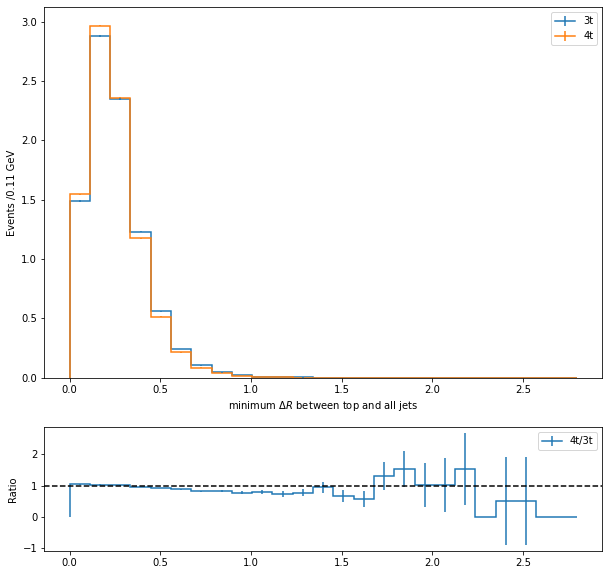

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([min_delta_r_3t,min_delta_r_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1])
ax[0].set_xlabel(r'minimum $\Delta R $ between top and all jets')
plt.show()

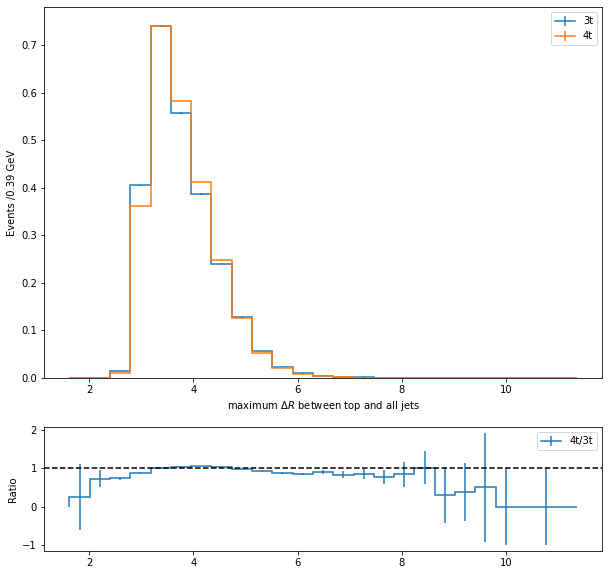

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([max_delta_r_3t,max_delta_r_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1])
ax[0].set_xlabel(r'maximum $\Delta R $ between top and all jets')
plt.show()

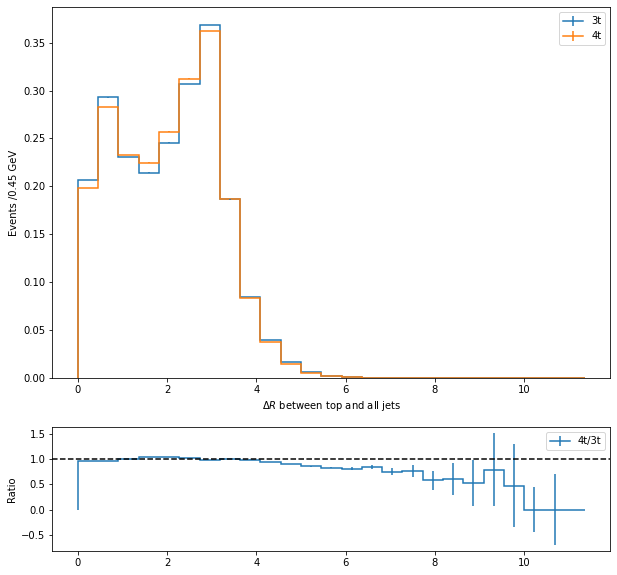

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([all_delta_r_3t,all_delta_r_4t], 25, ['3t','4t'], ax[0], ratio_axes=ax[1])
ax[0].set_xlabel(r'$\Delta R $ between top and all jets')
plt.show()

### ECF

In [ ]:
def compute_ecf_2(jets):
    duos = ak.combinations(jets,2,axis=1)
    delta_r = duos["0"].deltaR(duos["1"])
    ecf = ak.sum(duos["0"].pt*duos["1"].pt*delta_r,axis=1)
    print(ecf)
    return ecf

ecf_2_3t_dm = compute_ecf_2(jets_3t_dm)
ecf_2_4t_dm = compute_ecf_2(jets_4t_dm)

[7.45e+05, 2.82e+05, 6.74e+05, 2.67e+05, ..., 9.59e+05, 1.05e+06, 1.04e+06]
[5.12e+05, 1.15e+06, 5.62e+05, 2.78e+05, ..., 5.61e+05, 1.23e+06, 3.12e+06]


In [ ]:
def compute_ecf_3(jets):
    duos = ak.combinations(jets,3,axis=1)
    delta_r_01 = duos["0"].deltaR(duos["1"])
    delta_r_02 = duos["0"].deltaR(duos["2"])
    delta_r_12 = duos["1"].deltaR(duos["2"])
    ecf = ak.sum(duos["0"].pt*duos["1"].pt*duos["2"].pt*delta_r_01*delta_r_02*delta_r_12,axis=1)
    print(ecf)
    return ecf
ecf_3_3t_dm = compute_ecf_3(jets_3t_dm)
ecf_3_4t_dm = compute_ecf_3(jets_4t_dm)

[1.1e+09, 1.65e+08, 3.58e+08, 1.38e+08, ..., 7.73e+08, 1.01e+09, 1.11e+09]
[3.22e+08, 1.71e+09, 5.77e+08, 1.49e+08, ..., 5.18e+08, 1.62e+09, 7.29e+09]


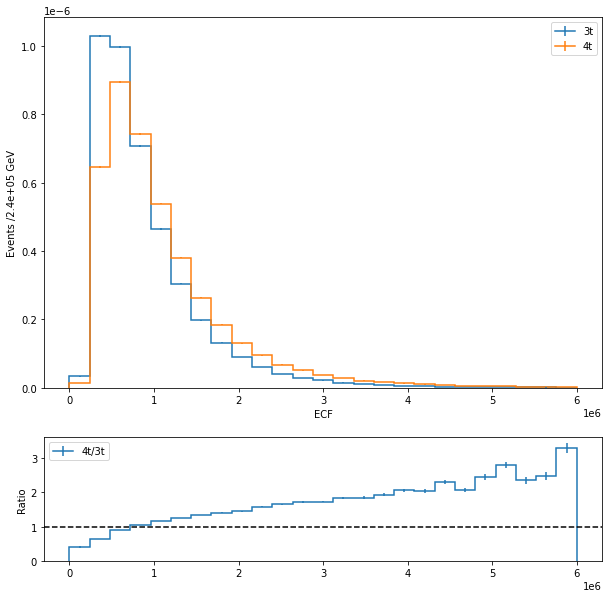

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([ecf_2_3t_dm,ecf_2_4t_dm], 25, ['3t','4t'], ax[0], ratio_axes=ax[1],set_range=(0,6e6))
ax[0].set_xlabel(r'ECF')
plt.show()

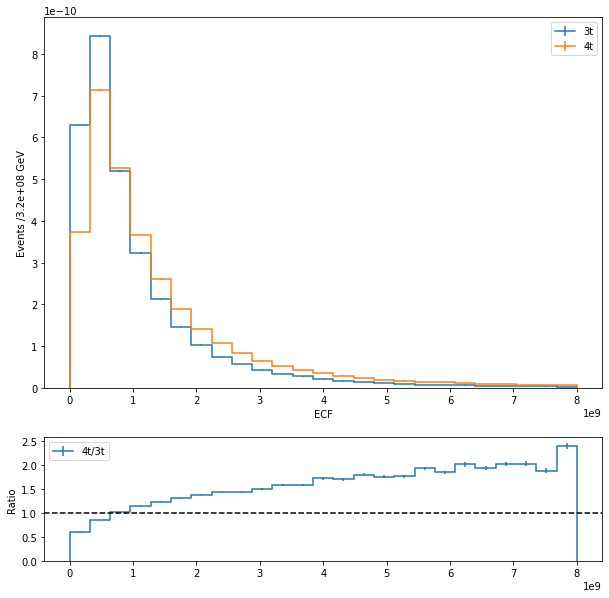

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
histogram([ecf_3_3t_dm,ecf_3_4t_dm], 25, ['3t','4t'], ax[0], ratio_axes=ax[1],set_range=(0,8e9))
ax[0].set_xlabel(r'ECF')
plt.show()